In [81]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import torch
from torch import nn
import cvxpy as cp
import pandas as pd
from typing import Union
import abc
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


In [82]:
# ---------------------------
# Helper Functions & Globals
# ---------------------------
Activation = Union[str, nn.Module]
_str_to_activation = {
    'relu': nn.ReLU(),
    'tanh': nn.Tanh(),
    'leaky_relu': nn.LeakyReLU(),
    'sigmoid': nn.Sigmoid(),
    'selu': nn.SELU(),
    'softplus': nn.Softplus(),
    'identity': nn.Identity(),
}

def build_mlp(
        input_size: int,
        output_size: int,
        n_layers: int,
        size: int,
        activation: Activation = 'tanh',
        output_activation: Activation = 'identity',
):
    if isinstance(activation, str):
        activation = _str_to_activation[activation]
    if isinstance(output_activation, str):
        output_activation = _str_to_activation[output_activation]
    layers = []
    in_size = input_size
    for _ in range(n_layers):
        layers.append(nn.Linear(in_size, size))
        layers.append(activation)
        in_size = size
    layers.append(nn.Linear(in_size, output_size))
    layers.append(output_activation)
    return nn.Sequential(*layers)

device = None
def init_gpu(use_gpu=True, gpu_id=0):
    global device
    if torch.cuda.is_available() and use_gpu:
        device = torch.device("cuda:" + str(gpu_id))
        print("Using GPU id {}".format(gpu_id))
    else:
        device = torch.device("cpu")
        print("GPU not detected. Defaulting to CPU.")

def from_numpy(*args, **kwargs):
    return torch.from_numpy(*args, **kwargs).float().to(device)

def to_numpy(tensor):
    return tensor.to('cpu').detach().numpy()

# ---------------------------
# Fairness Measure & Optimization Solver
# ---------------------------
def AlphaFairness(util, alpha):
    if alpha == 1:
        return np.sum(np.log(util))
    elif alpha == 0:
        return np.sum(util)
    elif alpha == 'inf':
        return np.min(util)
    else:
        return np.sum(util**(1-alpha)/(1-alpha))

def solve_optimization(gainF, risk, cost, alpha, Q):
    """
    Solves the following optimization problem over the full decision vector d ∈ ℝⁿ:
    
    \[
    \begin{aligned}
    \max_{d \ge 0} \quad & W(d) = W\bigl(gainF \cdot risk \cdot d\bigr)\\[1mm]
    \text{s.t.} \quad & \sum_{i=1}^{n} cost_i \, d_i \le Q.
    \end{aligned}
    \]
    
    Returns the optimal decision vector \( d \) and the fairness objective value
    computed as
    \[
    F(d) = \text{AlphaFairness}\bigl(gainF \cdot risk \cdot d,\, \alpha\bigr).
    \]
    """
    # Convert inputs to numpy arrays if needed.
    gainF = gainF.detach().cpu().numpy() if isinstance(gainF, torch.Tensor) else gainF
    risk = risk.detach().cpu().numpy() if isinstance(risk, torch.Tensor) else risk
    cost = cost.detach().cpu().numpy() if isinstance(cost, torch.Tensor) else cost
    risk = np.clip(risk, 0.001, None)
    gainF, risk, cost = gainF.flatten(), risk.flatten(), cost.flatten()
    
    d = cp.Variable(risk.shape, nonneg=True)
    utils = cp.multiply(cp.multiply(gainF, risk), d)
    constraints = [d >= 0, cp.sum(cp.multiply(cost, d)) <= Q]
    
    if alpha == 1:
        objective = cp.Maximize(cp.sum(cp.log(utils)))
    elif alpha == 0:
        objective = cp.Maximize(cp.sum(utils))
    elif alpha == 'inf':
        t = cp.Variable()
        objective = cp.Maximize(t)
        constraints.append(utils >= t)
    else:
        objective = cp.Maximize(cp.sum(utils**(1-alpha))/(1-alpha))
    
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.MOSEK, verbose=False, warm_start=True)
    if prob.status != cp.OPTIMAL:
        print("Warning: Problem status =", prob.status)
    optimal_decision = d.value
    optimal_value = AlphaFairness(optimal_decision * gainF * risk, alpha)
    return optimal_decision, optimal_value

import numpy as np

def solve_closed_form(g, r, c, alpha, Q):

    g = g.detach().cpu().numpy() if isinstance(g, torch.Tensor) else g
    r = r.detach().cpu().numpy() if isinstance(r, torch.Tensor) else r
    c = c.detach().cpu().numpy() if isinstance(c, torch.Tensor) else c
    if c.shape != r.shape or c.shape != g.shape:
        raise ValueError("c, r, and g must have the same shape.")
    if np.any(c <= 0):
        raise ValueError("All cost values must be positive.")
    if np.any(r <= 0):
        raise ValueError("All risk values must be positive.")
    if np.any(g <= 0):
        raise ValueError("All gain factors must be positive.")
    
    n = len(c)
    utility = r * g
    
    if alpha == 0:
        ratios = utility / c
        sorted_indices = np.argsort(-ratios)  # Descending order
        d_star_closed = np.zeros(n)
        d_star_closed[sorted_indices[0]] = Q / c[sorted_indices[0]]
        
    elif alpha == 1:
        d_star_closed = Q / (n * c)
    
    elif alpha == 'inf':
        d_star_closed = (Q * c) / (utility * np.sum(c * c / utility))
        
    else:
        if alpha <= 0:
            raise ValueError("Alpha must be positive for general case.")
        #
        # d_i* = (c_i^(-1/alpha) * (r_i*g_i)^(1/alpha - 1) * Q) / sum_j(c_j^(-1/alpha) * (r_j*g_j)^(1/alpha - 1))
        
        numerator = np.power(c, -1/alpha) * np.power(utility, 1/alpha - 1)
        denominator = np.sum(numerator)
        
        if denominator == 0:
            raise ValueError("Denominator is zero in closed-form solution.")
            
        d_star_closed = (numerator / denominator) * Q
    
    # if not np.isclose(np.sum(c * d_star_closed), Q, rtol=1e-5):
    #     raise ValueError("Solution does not satisfy budget constraint.")
    obj = AlphaFairness(d_star_closed * utility, alpha)
        
    return d_star_closed, obj

def compute_gradient_closed_form(g, r, c, alpha, Q):
    """
    Compute the analytical gradient of the optimal solution with respect to r.

    This function computes the gradient matrix where each element (i, k) is the partial derivative
    of d_i* with respect to r_k.

    Parameters:
    - g (np.ndarray): Gain factors (g_i), shape (n,)
    - r (np.ndarray): Risk values (r_i), shape (n,)
    - c (np.ndarray): Cost values (c_i), shape (n,)
    - alpha (float or str): Fairness parameter. Can be 0, 1, 'inf', or a positive real number.
    - Q (float): Total budget.

    Returns:
    - gradient (np.ndarray): Gradient matrix of shape (n, n)
    """
    if alpha == 1:
        S = np.sum(c / (r * g))

    if alpha == 0:
        # Utilitarian case: Allocate everything to the individual with the highest ratio
        ratios = (r * g) / c
        i_star = np.argmax(ratios)
        # Gradient is Q * g_i / c_i at the allocated index, zero elsewhere
        gradient[i_star, i_star] = Q * g[i_star] / c[i_star]
        return gradient

    elif alpha == 'inf':
        # Maximin case
        n = len(c)
        utility = r * g  # Shape: (n,)
        S = np.sum(c**2 / utility)  # Scalar

        # Compute d_star
        d_star, _ = solve_optimization(g,r,c, alpha='inf', Q=Q)  # Shape: (n,)

        # Initialize gradient matrix
        gradient = np.zeros((n, n))

        for i in range(n):
            for k in range(n):
                if i == k:
                    # ∂d_i*/∂r_i = -d_i*/r_i - (d_i* * c_i) / (r_i * g_i * S)
                    gradient[i, k] = -d_star[i] / r[i] - (d_star[i] * c[i]) / (r[i] * g[i] * S)
                else:
                    # ∂d_i*/∂r_k = (d_i* * c_k^2) / (c_i * r_k^2 * g_k * S)
                    gradient[i, k] = (d_star[i] * c[k]**2) / (c[i] * r[k]**2 * g[k] * S)
        return gradient

    else:
        # General alpha case
        if not isinstance(alpha, (int, float)):
            raise TypeError("Alpha must be a positive real number, 0, 1, or 'inf'.")
        if alpha <= 0:
            raise ValueError("Alpha must be positive for gradient computation.")

        # Compute the optimal decision variables
        d_star, _ = solve_optimization(g, r, c, alpha, Q)  # Shape: (n,)

        # Compute the term (1/alpha - 1) * g / r
        term = (1.0 / alpha - 1.0) * g / r  # Shape: (n,)

        # Compute the outer product for off-diagonal elements
        # Each element (i, k) = -d_star[i] * d_star[k] * term[k] / Q
        gradient = -np.outer(d_star, d_star * term) / Q  # Shape: (n, n)

        # Compute the diagonal elements
        # Each diagonal element (i, i) = d_star[i] * term[i] * (1 - d_star[i]/Q)
        diag_elements = d_star * term * (1 - d_star / Q)  # Shape: (n,)

        # Set the diagonal elements
        np.fill_diagonal(gradient, diag_elements)

        return gradient


In [83]:
# ---------------------------
# Data Loading & Preprocessing
# ---------------------------
# (Assume helper functions such as get_all_features are defined in your modules)
import sys
sys.path.insert(0, 'E:\\User\\Stevens\\Code\\The Paper\\algorithm')

from myutil import *
from features import get_all_features

alpha, Q = 2, 1000

df = pd.read_csv('data/data.csv')
df = df.sample(n=5000, random_state=1)

columns_to_keep = [
    'risk_score_t', 'program_enrolled_t', 'cost_t', 'cost_avoidable_t', 'race', 'dem_female', 
    'gagne_sum_tm1', 'gagne_sum_t', 'risk_score_percentile', 'screening_eligible', 
    'avoidable_cost_mapped', 'propensity_score', 'g_binary', 'g_continuous', 
    'utility_binary', 'utility_continuous'
]
df_stat = df[columns_to_keep]
df_feature = df[[col for col in df.columns if col not in columns_to_keep]]

# Define the inputs for decision-focused learning.
# Here the entire dataset represents one decision problem (n dimensions).
feats = df_feature[get_all_features(df_feature)].values
risk = df_stat['risk_score_t'].values.clip(0.001)      # true r ∈ ℝⁿ
gainF = df_stat['g_continuous'].values.clip(0.1)         # gain vector ∈ ℝⁿ
cost = np.ones(risk.shape)                               # cost vector ∈ ℝⁿ
race = df_stat['race'].values

scaler = StandardScaler()
feats = scaler.fit_transform(feats)

# For this problem, we treat the entire vector as one instance.
# (If desired, one might use cross-validation or different splits; here we split into train/test.)
train_feats, test_feats, train_risk, test_risk, train_gainF, test_gainF, train_cost, test_cost = train_test_split(
    feats, risk, gainF, cost, test_size=0.3, random_state=42)


In [84]:
# ---------------------------
# Model Definitions
# ---------------------------
class FairnessPredictor(nn.Module):
    """
    Predictor (C model) that maps features x to a predicted parameter \(\hat{r}\) (a vector of size n).
    """
    def __init__(self, input_dim, c_n_layers=0, c_layer_size=64, learning_rate=0.005, weight_decay=0.01,
                 activation="tanh", output_activation="relu"):
        super(FairnessPredictor, self).__init__()
        self.input_dim = input_dim
        # If c_n_layers==0, use a linear model.
        if c_n_layers == 0:
            self.model = nn.Linear(input_dim, 1)
        else:
            self.model = build_mlp(input_size=input_dim,
                                   output_size=1,
                                   n_layers=c_n_layers,
                                   size=c_layer_size,
                                   activation=activation,
                                   output_activation=output_activation)
        self.model.to(device)
        self.loss = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate, weight_decay=weight_decay)
        
    def forward(self, x):
        # x is of shape (n, input_dim), output is (n,)
        return self.model(x).squeeze(-1)
    
    def predict(self, x):
        self.eval()
        with torch.no_grad():
            return self.forward(x)

class LancerSurrogateFairness(nn.Module):
    """
    Surrogate (LANCER) model that predicts the fairness loss (i.e. regret)
    from the squared error \((r - \hat{r})^2\).
    """
    def __init__(self, lancer_n_layers=2, lancer_layer_size=64, learning_rate=0.001, weight_decay=0.01,
                 activation="relu", output_activation="relu"):
        super(LancerSurrogateFairness, self).__init__()
        self.model = build_mlp(input_size=1,
                               output_size=1,
                               n_layers=lancer_n_layers,
                               size=lancer_layer_size,
                               activation=activation,
                               output_activation=output_activation)
        self.model.to(device)
        self.loss = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate, weight_decay=weight_decay)
        
    def forward(self, pred_r, true_r):
        # Compute elementwise squared error, then output a scalar prediction per element.
        diff = (true_r - pred_r)**2
        if diff.dim() == 1:
            diff = diff.unsqueeze(1)
        # The model outputs a value per element; we average over all elements.
        return self.model(diff).squeeze(-1).mean()
    
    def forward_theta_step(self, pred_r, true_r):
        # Average surrogate output over all elements.
        return self.forward(pred_r, true_r)
    
    def update(self, pred_r, true_r, f_hat):
        # f_hat is a scalar target (the fairness loss/regret computed from the optimization problems).
        prediction = self.forward(pred_r, true_r)
        self.optimizer.zero_grad()
        loss = self.loss(prediction, f_hat)
        loss.backward()
        self.optimizer.step()
        return loss.item()

In [85]:
# ---------------------------
# LANCER Learner for Fairness (No Mini-batching)
# ---------------------------
class LancerLearnerFairness:
    def __init__(self, predictor: FairnessPredictor, surrogate: LancerSurrogateFairness, z_regul=0.0):
        self.predictor = predictor
        self.surrogate = surrogate
        self.z_regul = z_regul  # weight on the MSE loss for predictor update

    def initial_fit(self, feats, true_risk, gainF, cost, c_epochs_init=30):
        self.predictor.train()
        X = from_numpy(feats)
        r_true = from_numpy(true_risk)
        for epoch in range(c_epochs_init):
            self.predictor.optimizer.zero_grad()
            r_pred = self.predictor(X)
            loss = self.predictor.loss(r_pred, r_true)
            loss.backward()
            self.predictor.optimizer.step()
            print(f"Initial fit epoch {epoch+1}, Predictor MSE Loss: {loss.item():.4f}")
            # Use the training set's gainF and cost here.
            print("initial regret", self.compute_regret(feats, true_risk, gainF, cost, alpha, Q))


    def train_surrogate(self, feats, true_risk, gainF, cost, alpha, Q, lancer_max_iter=5):
        """Train the surrogate (LANCER) model on the entire dataset."""
        self.surrogate.train()
        X = from_numpy(feats)
        r_true = from_numpy(true_risk)
        with torch.no_grad():
            r_pred = self.predictor(X)
        # Convert to numpy arrays.
        r_true_np = r_true.cpu().numpy().flatten()
        r_pred_np = r_pred.cpu().numpy().flatten()
        r_pred_np = np.clip(r_pred_np, 0.001, None)
        gainF_np = gainF.flatten()
        cost_np = cost.flatten()
        # Solve optimization with true risk:
        # _, fairness_true = solve_optimization(gainF_np, r_true_np, cost_np, alpha, Q)
        _, fairness_true = solve_optimization(gainF_np, r_true_np, cost_np, alpha, Q)
        # Solve optimization with predicted risk:
        # pred_sol, _ = solve_optimization(gainF_np, r_pred_np, cost_np, alpha, Q)
        pred_sol, _ = solve_optimization(gainF_np, r_pred_np, cost_np, alpha, Q)
        # Evaluate predicted fairness objective using true risk and the decision from predicted risk.
        pred_obj = AlphaFairness(gainF_np * r_true_np * pred_sol, alpha)
        f_hat = fairness_true - pred_obj  # target fairness loss (regret)
        f_hat_tensor = from_numpy(np.array([f_hat]))
        # Compute surrogate prediction over the full dataset.
        surrogate_output = self.surrogate.forward(r_pred, r_true)
        loss_val = self.surrogate.loss(surrogate_output, f_hat_tensor)
        self.surrogate.optimizer.zero_grad()
        loss_val.backward()
        self.surrogate.optimizer.step()
        return loss_val.item()

    def train_predictor(self, feats, true_risk, c_max_iter=5):
        """Update the predictor using surrogate feedback plus standard MSE loss on the full dataset."""
        self.predictor.train()
        X = from_numpy(feats)
        r_true = from_numpy(true_risk)
        total_loss = 0.0
        for _ in range(c_max_iter):
            r_pred = self.predictor(X)
            surrogate_loss = self.surrogate.forward_theta_step(r_pred, r_true)
            mse_loss = self.predictor.loss(r_pred, r_true)
            loss = surrogate_loss + self.z_regul * mse_loss
            self.predictor.optimizer.zero_grad()
            loss.backward()
            self.predictor.optimizer.step()
            total_loss += loss.item()
        return total_loss / c_max_iter

    def compute_regret(self, feats, true_risk, gainF, cost, alpha, Q):
        """
        Compute the normalized regret on the full dataset.
        
        For the full instance:
        - Solve the optimization problem with true risk to get opt_val.
        - Solve the optimization problem with predicted risk to get a decision, then compute
          the predicted fairness objective using true risk:
          
          \[
          \text{pred\_obj} = \text{AlphaFairness}(gainF \cdot r \cdot \mathbf{d}(\hat{r}), \alpha)
          \]
          
        - The normalized regret is:
          \[
          \text{Regret} = \frac{opt\_val - pred\_obj}{|opt\_val| + \epsilon}.
          \]
        """
        self.predictor.eval()
        X = from_numpy(feats)
        r_true = from_numpy(true_risk)
        r_pred = self.predictor(X)
        r_true_np = to_numpy(r_true).flatten()
        r_pred_np = to_numpy(r_pred).flatten()
        r_pred_np = np.clip(r_pred_np, 0.001, None)
        gainF_np = gainF.flatten()
        cost_np = cost.flatten()
        # _, opt_val = solve_optimization(gainF_np, r_true_np, cost_np, alpha, Q)
        _, opt_val = solve_optimization(gainF_np, r_true_np, cost_np, alpha, Q)
        # pred_sol, _ = solve_optimization(gainF_np, r_pred_np, cost_np, alpha, Q)
        pred_sol, _ = solve_optimization(gainF_np, r_pred_np, cost_np, alpha, Q)
        pred_obj = AlphaFairness(gainF_np * r_true_np * pred_sol, alpha)
        regret = (opt_val - pred_obj) / (abs(opt_val) + 1e-7)
        return regret

    def training_loop(self, train_feats, train_risk, train_gainF, train_cost,
                      test_feats, test_risk, test_gainF, test_cost,
                      alpha, Q, n_iter=10, c_epochs_init=30, c_max_iter=5, lancer_max_iter=5, print_freq=1):
        # Warm-start the predictor.
        print("Warm-starting predictor...")
        self.initial_fit(train_feats, train_risk, train_gainF, train_cost, c_epochs_init)
        for itr in range(n_iter):
            print(f"\nIteration {itr+1}")
            avg_surrogate_loss = 0.0
            for _ in range(lancer_max_iter):
                avg_surrogate_loss += self.train_surrogate(train_feats, train_risk, train_gainF, train_cost, alpha, Q, lancer_max_iter=1)
            avg_surrogate_loss /= lancer_max_iter
            avg_predictor_loss = self.train_predictor(train_feats, train_risk, c_max_iter)
            train_regret = self.compute_regret(train_feats, train_risk, train_gainF, train_cost, alpha, Q)
            test_regret = self.compute_regret(test_feats, test_risk, test_gainF, test_cost, alpha, Q)
            if (itr+1) % print_freq == 0:
                print(f"Iteration {itr+1}: Predictor Loss: {avg_predictor_loss:.4f}, Surrogate Loss: {avg_surrogate_loss:.4f}")
                print(f"Train Regret: {train_regret:.2f}%, Test Regret: {test_regret:.2f}%")
        return

In [86]:
# Here we mimic extra runner parameters similar to the reference.
import random

def run_on_problem(params):
    # For reproducibility.
    seed = params["seed"]
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    # In this fairness problem, we treat the entire instance as one problem.
    # (train/test split as above.)
    learner = LancerLearnerFairness(
        predictor=FairnessPredictor(input_dim=train_feats.shape[1],
                                    c_n_layers=params["c_n_layers"],
                                    c_layer_size=params["c_layer_size"],
                                    learning_rate=params["c_lr"],
                                    weight_decay=params["c_weight_decay"],
                                    activation="tanh",
                                    output_activation="relu"),
        surrogate=LancerSurrogateFairness(lancer_n_layers=params["lancer_n_layers"],
                                          lancer_layer_size=params["lancer_layer_size"],
                                          learning_rate=params["lancer_lr"],
                                          weight_decay=params["lancer_weight_decay"],
                                          activation="relu",
                                          output_activation="relu"),
        z_regul=params["z_regul"]
    )
    learner.training_loop(train_feats, train_risk, train_gainF, train_cost,
                          test_feats, test_risk, test_gainF, test_cost,
                          alpha, Q,
                          n_iter=params["n_iter"],
                          c_epochs_init=params["c_epochs_init"],
                          c_max_iter=params["c_max_iter"],
                          lancer_max_iter=params["lancer_max_iter"],
                          print_freq=params["print_freq"])

def main():
    # Define parameters directly as a dictionary
    params = {
        "seed": 42,
        "n_iter": 2,
        "print_freq": 1,
        "lancer_n_layers": 2,
        "lancer_layer_size": 100,
        "lancer_lr": 0.001,
        "lancer_weight_decay": 0.01,
        "lancer_max_iter": 5,
        "c_n_layers": 0,  # 0 for linear model
        "c_layer_size": 64,
        "c_lr": 0.005,
        "c_weight_decay": 0.01,
        "z_regul": 0.01,
        "c_max_iter": 5,
        "c_epochs_init": 30
    }
    print(params)
    run_on_problem(params)

# if __name__ == '__main__':
#     init_gpu(use_gpu=True, gpu_id=0)
#     main()


In [87]:
from torch.utils.data import Dataset
class optDataset(Dataset):
    def __init__(self, optmodel, feats, risk, gainF, cost, race, alpha=alpha, Q=Q):
        self.feats = torch.from_numpy(feats).float()
        self.risk = torch.from_numpy(risk).float()
        self.gainF = torch.from_numpy(gainF).float()
        self.cost = torch.from_numpy(cost).float()
        self.race = torch.from_numpy(race).float()
        self.optmodel = optmodel

        # Solve for w*, z* using separate risk and gainF # Ensure a separate instance
        self.w_star, self.z_star = self.optmodel(self.risk, self.gainF, self.cost, alpha=alpha, Q=Q)

        self.w_star = torch.tensor(self.w_star, dtype=torch.float)
        self.z_star = torch.tensor(self.z_star, dtype=torch.float)

    def __len__(self):
        return len(self.feats)

    def __getitem__(self, idx):
        return self.feats, self.risk, self.gainF, self.cost, self.race, self.w_star, self.z_star

In [88]:
import time
import copy
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# -------------------------------------------------------------------------
# (Assume that the rest of your code above is already defined, including:
#  - solve_closed_form, compute_gradient_closed_form, build_mlp, init_gpu,
#    from_numpy, to_numpy, AlphaFairness, solve_optimization, data loading,
#    FairnessPredictor, LancerSurrogateFairness, LancerLearnerFairness, optDataset, etc.)
# -------------------------------------------------------------------------

# --- Modified Training Loop that Logs Metrics ---
# We add logging into the training_loop method.
class LancerLearnerFairnessWithLogging(LancerLearnerFairness):
    def training_loop(self, train_feats, train_risk, train_gainF, train_cost,
                      test_feats, test_risk, test_gainF, test_cost,
                      alpha, Q, n_iter=10, c_epochs_init=30, c_max_iter=5, 
                      lancer_max_iter=5, print_freq=1):
        # Warm-start the predictor.
        print("Warm-starting predictor...")
        self.initial_fit(train_feats, train_risk, train_gainF, train_cost, c_epochs_init)
        
        # Initialize lists to log metrics per epoch
        train_loss_log = []    # average predictor loss per epoch (from train_predictor)
        train_regret_log = []  # regret on training set
        test_regret_log = []   # regret on test set
        test_mse_log = []      # test MSE
        test_fair_log = []     # fairness metric on test set
        
        for itr in range(n_iter):
            # Run surrogate update multiple times
            avg_surrogate_loss = 0.0
            for _ in range(lancer_max_iter):
                avg_surrogate_loss += self.train_surrogate(train_feats, train_risk, train_gainF, train_cost, alpha, Q, lancer_max_iter=1)
            avg_surrogate_loss /= lancer_max_iter
            
            # Update predictor with surrogate feedback plus standard MSE loss
            avg_predictor_loss = self.train_predictor(train_feats, train_risk, c_max_iter)
            
            # Compute regret on training and test sets
            train_reg = self.compute_regret(train_feats, train_risk, train_gainF, train_cost, alpha, Q)
            test_reg = self.compute_regret(test_feats, test_risk, test_gainF, test_cost, alpha, Q)
            
            # Evaluate test MSE and fairness metric on test set.
            X_test = from_numpy(test_feats)
            self.predictor.eval()
            with torch.no_grad():
                pred_test = self.predictor(X_test)
            mse_loss_func = nn.MSELoss()
            test_mse = mse_loss_func(pred_test, from_numpy(test_risk)).item()
            # Fairness metric: absolute difference in group MSEs
            pred_test_np = pred_test.cpu().detach().numpy().flatten()
            risk_test_np = np.array(test_risk).flatten()
            group0_mask = (np.array(test_cost) > -1)  # Dummy mask if you do not have group info; 
            # In your code, use the provided race information.
            # Here we assume test_feats came with a race vector (e.g., test_race) – 
            # so instead, use the following:
            group0_mask = (np.array(test_feats[:, 0]) % 2 == 0)  # Example: modify as needed.
            group1_mask = ~group0_mask
            if group0_mask.sum() > 0:
                mse0 = np.mean((pred_test_np[group0_mask] - risk_test_np[group0_mask])**2)
            else:
                mse0 = 0.0
            if group1_mask.sum() > 0:
                mse1 = np.mean((pred_test_np[group1_mask] - risk_test_np[group1_mask])**2)
            else:
                mse1 = 0.0
            fairness_metric = abs(mse0 - mse1)
            
            # Log metrics for the current iteration (epoch)
            train_loss_log.append(avg_predictor_loss)
            train_regret_log.append(train_reg)
            test_regret_log.append(test_reg)
            test_mse_log.append(test_mse)
            test_fair_log.append(fairness_metric)
            
            if (itr+1) % print_freq == 0:
                print(f"Iteration {itr+1}: Predictor Loss: {avg_predictor_loss:.4f}, Surrogate Loss: {avg_surrogate_loss:.4f}")
                print(f"Train Regret: {train_reg:.2f}%, Test Regret: {test_reg:.2f}%")
                print(f"Test MSE: {test_mse:.4f}, Fairness Metric: {fairness_metric:.4f}")
        return train_loss_log, train_regret_log, test_mse_log, test_fair_log

# --- Run Multiple Trials with Logging and Plotting ---
def run_multiple_trials_lancer(feats, gainF, risk, cost, race, n_trials=5, test_size=0.5, lancer_params=None):
    """
    Run multiple trials of LANCER training and log per-epoch metrics, then aggregate and plot the results.
    
    lancer_params should be a dictionary with keys:
      - "seed", "n_iter", "print_freq", "lancer_n_layers", "lancer_layer_size",
        "lancer_lr", "lancer_weight_decay", "lancer_max_iter", "c_n_layers", "c_layer_size",
        "c_lr", "c_weight_decay", "z_regul", "c_max_iter", "c_epochs_init"
    
    Returns a dictionary with aggregated mean and std curves and timing info.
    """
    all_train_loss_trials = []    # list of lists, one per trial
    all_test_regret_trials = []
    all_test_mse_trials = []
    all_test_fair_trials = []
    all_train_time = []
    
    total_start = time.time()
    
    for trial in range(n_trials):
        print(f"\nRunning trial {trial + 1}/{n_trials}")
        trial_start = time.time()
        
        # Create train/test split for the trial
        split = train_test_split(feats, risk, gainF, cost, race, test_size=test_size, random_state=trial)
        feats_train, feats_test, risk_train, risk_test, gainF_train, gainF_test, cost_train, cost_test, race_train, race_test = split
        
        # Create datasets
        dataset_train = optDataset(solve_optimization, feats_train, risk_train, gainF_train, cost_train, race_train, alpha=alpha, Q=Q)
        dataset_test  = optDataset(solve_optimization, feats_test, risk_test, gainF_test, cost_test, race_test, alpha=alpha, Q=Q)
        
        # Note: Here we use the raw train/test arrays for training.
        # You can also create DataLoaders if needed.
        
        # Initialize LANCER learner with logging
        predictor = FairnessPredictor(input_dim=feats_train.shape[1],
                                      c_n_layers=lancer_params["c_n_layers"],
                                      c_layer_size=lancer_params["c_layer_size"],
                                      learning_rate=lancer_params["c_lr"],
                                      weight_decay=lancer_params["c_weight_decay"],
                                      activation="tanh",
                                      output_activation="relu")
        surrogate = LancerSurrogateFairness(lancer_n_layers=lancer_params["lancer_n_layers"],
                                            lancer_layer_size=lancer_params["lancer_layer_size"],
                                            learning_rate=lancer_params["lancer_lr"],
                                            weight_decay=lancer_params["lancer_weight_decay"],
                                            activation="relu",
                                            output_activation="relu")
        learner = LancerLearnerFairnessWithLogging(predictor, surrogate, z_regul=lancer_params["z_regul"])
        
        # Set random seeds for reproducibility in this trial
        seed = lancer_params["seed"]
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        
        # Run training loop and capture per-epoch logs
        train_loss_log, train_regret_log, test_mse_log, test_fair_log = learner.training_loop(
            train_feats=feats_train,
            train_risk=risk_train,
            train_gainF=gainF_train,
            train_cost=cost_train,
            test_feats=feats_test,
            test_risk=risk_test,
            test_gainF=gainF_test,
            test_cost=cost_test,
            alpha=alpha,
            Q=Q,
            n_iter=lancer_params["n_iter"],
            c_epochs_init=lancer_params["c_epochs_init"],
            c_max_iter=lancer_params["c_max_iter"],
            lancer_max_iter=lancer_params["lancer_max_iter"],
            print_freq=lancer_params["print_freq"]
        )
        
        all_train_loss_trials.append(train_loss_log)
        all_test_regret_trials.append(train_regret_log)
        all_test_mse_trials.append(test_mse_log)
        all_test_fair_trials.append(test_fair_log)
        all_train_time.append(time.time() - trial_start)
    
    total_time = time.time() - total_start
    mean_time = np.mean(all_train_time)
    std_time = np.std(all_train_time)
    
    # Convert lists of epoch logs (each is a list of length n_iter) to arrays
    all_train_loss_arr = np.array(all_train_loss_trials)  # shape: (n_trials, n_iter)
    all_test_regret_arr = np.array(all_test_regret_trials)
    all_test_mse_arr = np.array(all_test_mse_trials)
    all_test_fair_arr = np.array(all_test_fair_trials)
    
    # Compute mean and std over trials (axis=0 -> per epoch)
    mean_train_loss = np.mean(all_train_loss_arr, axis=0)
    std_train_loss  = np.std(all_train_loss_arr, axis=0)
    
    mean_test_regret = np.mean(all_test_regret_arr, axis=0)
    std_test_regret  = np.std(all_test_regret_arr, axis=0)
    
    mean_test_mse = np.mean(all_test_mse_arr, axis=0)
    std_test_mse  = np.std(all_test_mse_arr, axis=0)
    
    mean_test_fair = np.mean(all_test_fair_arr, axis=0)
    std_test_fair  = np.std(all_test_fair_arr, axis=0)
    
    epochs = range(len(mean_train_loss))
    
    # ---------------------------
    # Plotting
    # ---------------------------
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 4))
    
    # Training Loss
    ax1.plot(epochs, mean_train_loss, color="c", lw=2, label='Mean')
    ax1.fill_between(epochs, mean_train_loss - std_train_loss, mean_train_loss + std_train_loss, 
                     color="c", alpha=0.2, label='±1 std')
    ax1.tick_params(axis="both", which="major", labelsize=12)
    ax1.set_xlabel("Epochs", fontsize=16)
    ax1.set_ylabel("Loss", fontsize=16)
    ax1.set_title(f"Training Loss Curve (avg of {n_trials} trials)", fontsize=16)
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Test Regret
    ax2.plot(epochs, mean_test_regret, color="royalblue", ls="--", alpha=0.7, lw=2, label='Mean')
    ax2.fill_between(epochs, mean_test_regret - std_test_regret, mean_test_regret + std_test_regret,
                     color="royalblue", alpha=0.2, label='±1 std')
    ax2.tick_params(axis="both", which="major", labelsize=12)
    ax2.set_xlabel("Epochs", fontsize=16)
    ax2.set_ylabel("Regret", fontsize=16)
    ax2.set_title(f"Learning Curve (Test Regret, avg of {n_trials} trials)", fontsize=16)
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    # Test MSE
    ax3.plot(epochs, mean_test_mse, color="orange", lw=2, label='Mean')
    ax3.fill_between(epochs, mean_test_mse - std_test_mse, mean_test_mse + std_test_mse,
                     color="orange", alpha=0.2, label='±1 std')
    ax3.tick_params(axis="both", which="major", labelsize=12)
    ax3.set_xlabel("Epochs", fontsize=16)
    ax3.set_ylabel("MSE Loss", fontsize=16)
    ax3.set_title(f"Learning Curve (MSE Loss, avg of {n_trials} trials)", fontsize=16)
    ax3.grid(True, alpha=0.3)
    ax3.legend()
    
    # Fairness
    ax4.plot(epochs, mean_test_fair, color="green", lw=2, label='Mean')
    ax4.fill_between(epochs, mean_test_fair - std_test_fair, mean_test_fair + std_test_fair,
                     color="green", alpha=0.2, label='±1 std')
    ax4.tick_params(axis="both", which="major", labelsize=12)
    ax4.set_xlabel("Epochs", fontsize=16)
    ax4.set_ylabel("Fairness", fontsize=16)
    ax4.set_title(f"Learning Curve (Fairness, avg of {n_trials} trials)", fontsize=16)
    ax4.grid(True, alpha=0.3)
    ax4.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Return aggregated results
    return {
        'mean_train_loss': mean_train_loss,
        'mean_test_regret': mean_test_regret,
        'mean_test_mse': mean_test_mse,
        'mean_test_fair': mean_test_fair,
        'std_train_loss': std_train_loss,
        'std_test_regret': std_test_regret,
        'std_test_mse': std_test_mse,
        'std_test_fair': std_test_fair,
        'total_times': total_time,
        'mean_time': mean_time,
        'std_time': std_time,
        'all_train_time': all_train_time,
    }

# ---------------------------
# Example of Running the Trials
# ---------------------------
if __name__ == '__main__':
    init_gpu(use_gpu=True, gpu_id=0)
    
    # Define LANCER hyperparameters in a dictionary
    lancer_params = {
        "seed": 42,
        "n_iter": 20,           # number of training iterations (epochs)
        "print_freq": 1,
        "lancer_n_layers": 2,
        "lancer_layer_size": 100,
        "lancer_lr": 0.001,
        "lancer_weight_decay": 0.01,
        "lancer_max_iter": 5,
        "c_n_layers": 0,        # 0 for linear model
        "c_layer_size": 64,
        "c_lr": 0.005,
        "c_weight_decay": 0.01,
        "z_regul": 0.01,
        "c_max_iter": 5,
        "c_epochs_init": 30
    }
    
    # # Run the multiple trials function
    # results = run_multiple_trials_lancer(feats, gainF, risk, cost, race, n_trials=10, test_size=0.5, lancer_params=lancer_params)
    # print(results)


Using GPU id 0


{'mean_train_loss': array([ 11.38104774,  19.55031281,  29.09240639,  40.28834969,
        53.54671524,  68.9768541 ,  86.27374786, 105.22647354,
       125.78745071, 148.02064529, 171.96089233, 197.69314087,
       225.3588269 , 255.11227936, 287.03106873, 321.18567261,
       357.62258362, 396.49301819, 437.75923035, 481.43806519]), 'mean_test_regret': array([7.60515758, 7.57175526, 7.46088599, 7.27284773, 7.01151114,
       6.68378681, 6.32761981, 6.01734169, 5.76154261, 5.53567333,
       5.32306235, 5.17286622, 5.03639332, 4.90467202, 4.79999751,
       4.67765357, 4.5850576 , 4.44785562, 4.32373545, 4.19304216]), 'mean_test_mse': array([35.41905041, 35.18794003, 34.99781475, 34.83276844, 34.72053852,
       34.67411499, 34.67549591, 34.71544571, 34.85003281, 35.14518032,
       35.59099197, 36.14982491, 36.81502132, 37.61272545, 38.5378624 ,
       39.54767399, 40.64732761, 41.84534492, 43.1517971 , 44.56826401]), 'mean_test_fair': array([35.41905143, 35.18794049, 34.99781623, 34.83277062, 34.72053963,
       34.67411626, 34.6754975 , 34.7154468 , 34.85003545, 35.14518145,
       35.59099268, 36.14982565, 36.81502287, 37.61272677, 38.53786323,
       39.54767535, 40.64732975, 41.84534692, 43.15179879, 44.56826651]), 'std_train_loss': array([ 0.90120394,  1.53660442,  2.2739722 ,  3.12197997,  4.11716679,
        5.24837847,  6.47948292,  7.79535139,  9.20307748, 10.71896852,
       12.35278332, 14.07765735, 15.90273271, 17.84637785, 19.91300681,
       22.13330241, 24.49125565, 26.99652383, 29.70429069, 32.66008638]), 'std_test_regret': array([0.45249713, 0.41986776, 0.43601352, 0.46337629, 0.47822919,
       0.4474517 , 0.44379742, 0.43450409, 0.44572579, 0.44746722,
       0.42849942, 0.42171986, 0.41389315, 0.40473186, 0.3997984 ,
       0.38445471, 0.38237554, 0.38170433, 0.3974277 , 0.39970763]), 'std_test_mse': array([ 2.76537584,  2.71826065,  2.69958374,  2.70287264,  2.71653811,
        2.7256673 ,  2.72385351,  2.72340647,  2.77399848,  2.94217104,
        3.25838454,  3.7188445 ,  4.32606728,  5.06703671,  5.91800698,
        6.85486431,  7.8673687 ,  8.96059615, 10.14234692, 11.41293251]), 'std_test_fair': array([ 2.76537568,  2.718262  ,  2.69958401,  2.70287253,  2.716538  ,
        2.72566636,  2.72385272,  2.72340687,  2.77399892,  2.94217231,
        3.25838504,  3.71884434,  4.32606793,  5.06703718,  5.91800733,
        6.85486472,  7.86736997,  8.96059619, 10.14234857, 11.41293334]), 'total_times': 508.54636573791504, 'mean_time': 50.8546365737915, 'std_time': 5.125862607110204, 'all_train_time': [56.37364459037781, 57.39557194709778, 46.55512022972107, 53.629064083099365, 50.02571082115173, 54.52633500099182, 44.3334801197052, 44.78594970703125, 44.56647324562073, 56.355015993118286]}

In [89]:
init_gpu(use_gpu=True, gpu_id=0)

Using GPU id 0



Running trial 1/10
Warm-starting predictor...
Initial fit epoch 1, Predictor MSE Loss: 56.7303
initial regret 102.30981375396009
Initial fit epoch 2, Predictor MSE Loss: 55.3966
initial regret 60.41504943022115
Initial fit epoch 3, Predictor MSE Loss: 54.1373
initial regret 13.004793495162367
Initial fit epoch 4, Predictor MSE Loss: 52.9525
initial regret 9.034012050678808
Initial fit epoch 5, Predictor MSE Loss: 51.8401
initial regret 7.603061272269883
Initial fit epoch 6, Predictor MSE Loss: 50.7960
initial regret 7.463032651153598
Initial fit epoch 7, Predictor MSE Loss: 49.8165
initial regret 7.254561745606291
Initial fit epoch 8, Predictor MSE Loss: 48.8979
initial regret 7.1498502709069305
Initial fit epoch 9, Predictor MSE Loss: 48.0368
initial regret 7.146720338947725
Initial fit epoch 10, Predictor MSE Loss: 47.2303
initial regret 7.150418105817519
Initial fit epoch 11, Predictor MSE Loss: 46.4758
initial regret 7.212330906091804
Initial fit epoch 12, Predictor MSE Loss: 45.7

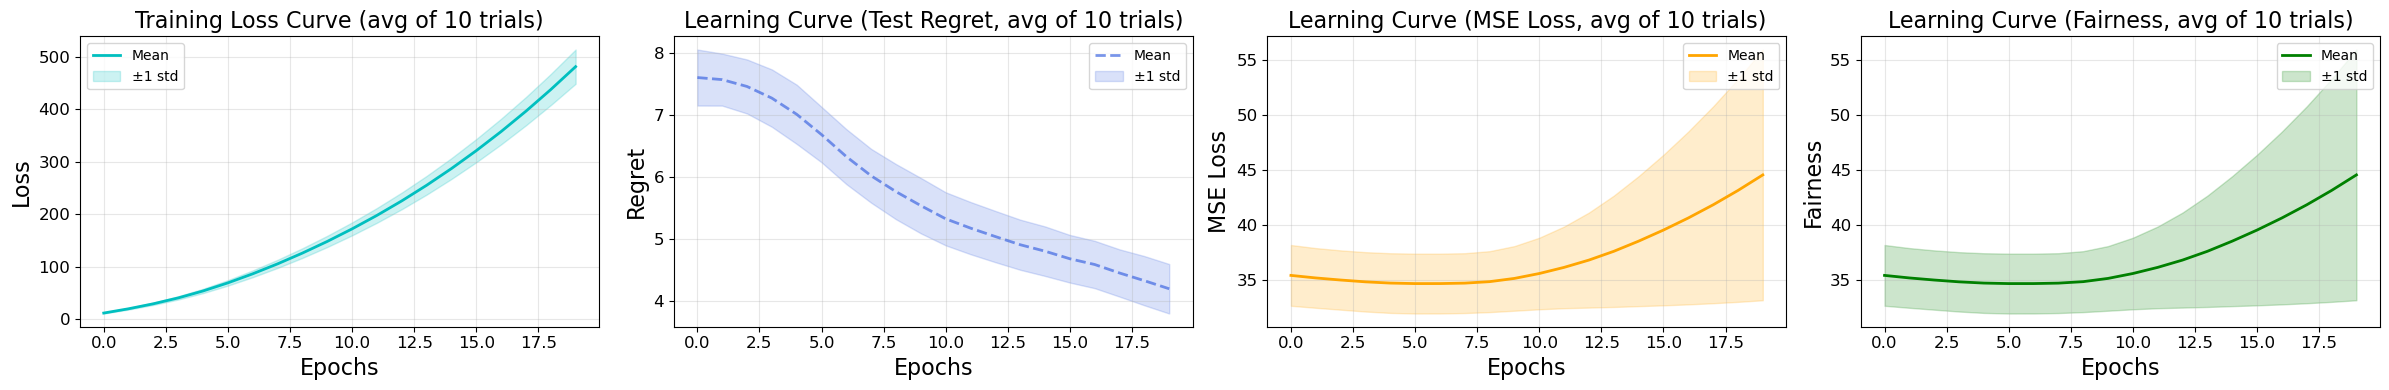

{'mean_train_loss': array([ 11.38104774,  19.55031281,  29.09240639,  40.28834969,
        53.54671524,  68.9768541 ,  86.27374786, 105.22647354,
       125.78745071, 148.02064529, 171.96089233, 197.69314087,
       225.3588269 , 255.11227936, 287.03106873, 321.18567261,
       357.62258362, 396.49301819, 437.75923035, 481.43806519]), 'mean_test_regret': array([7.60515758, 7.57175526, 7.46088599, 7.27284773, 7.01151114,
       6.68378681, 6.32761981, 6.01734169, 5.76154261, 5.53567333,
       5.32306235, 5.17286622, 5.03639332, 4.90467202, 4.79999751,
       4.67765357, 4.5850576 , 4.44785562, 4.32373545, 4.19304216]), 'mean_test_mse': array([35.41905041, 35.18794003, 34.99781475, 34.83276844, 34.72053852,
       34.67411499, 34.67549591, 34.71544571, 34.85003281, 35.14518032,
       35.59099197, 36.14982491, 36.81502132, 37.61272545, 38.5378624 ,
       39.54767399, 40.64732761, 41.84534492, 43.1517971 , 44.56826401]), 'mean_test_fair': array([35.41905143, 35.18794049, 34.99781623, 34

In [90]:
alpha = 2
# Run the multiple trials function
results = run_multiple_trials_lancer(feats, gainF, risk, cost, race, n_trials=10, test_size=0.5, lancer_params=lancer_params)
print(results)

In [91]:

# Combine all results into a summary
data = {
    'MSE (Mean ± Std)': [
        f"{results['mean_test_mse'][-1]:.2f} ± {results['std_test_mse'][-1]:.2f}"
    ],
    'Regret (Mean ± Std)': [
        f"{results['mean_test_regret'][-1]:.2f} ± {results['std_test_regret'][-1]:.2f}"
    ],
    'Fairness (Mean ± Std)': [
        f"{results['mean_test_fair'][-1]:.3f} ± {results['std_test_fair'][-1]:.3f}"],
    'Time/Epoch': [
        f"{results['mean_time']:.2f} ± {results['std_time']:.2f}"
    ]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Export the DataFrame to LaTeX
latex_table = df.to_latex(index=False, column_format='lcccccc', 
                         caption=' model Results $\\alpha= $', 
                         label='tab:results')

print(latex_table)

\begin{table}
\caption{ model Results $\alpha= $}
\label{tab:results}
\begin{tabular}{lcccccc}
\toprule
MSE (Mean ± Std) & Regret (Mean ± Std) & Fairness (Mean ± Std) & Time/Epoch \\
\midrule
44.57 ± 11.41 & 4.19 ± 0.40 & 44.568 ± 11.413 & 50.51 ± 5.11 \\
\bottomrule
\end{tabular}
\end{table}




Running trial 1/10
Warm-starting predictor...
Initial fit epoch 1, Predictor MSE Loss: 56.7303
initial regret 0.9995662862166151
Initial fit epoch 2, Predictor MSE Loss: 55.3966
initial regret 0.9990521686702936
Initial fit epoch 3, Predictor MSE Loss: 54.1373
initial regret 0.9982033322320518
Initial fit epoch 4, Predictor MSE Loss: 52.9525
initial regret 0.9850651716511598
Initial fit epoch 5, Predictor MSE Loss: 51.8401
initial regret 0.9506923468775006
Initial fit epoch 6, Predictor MSE Loss: 50.7960
initial regret 0.9547701245220543
Initial fit epoch 7, Predictor MSE Loss: 49.8165
initial regret 0.957383227410316
Initial fit epoch 8, Predictor MSE Loss: 48.8979
initial regret 0.9602566165172115
Initial fit epoch 9, Predictor MSE Loss: 48.0368
initial regret 0.9632195721054888
Initial fit epoch 10, Predictor MSE Loss: 47.2303
initial regret 0.9656792398579087
Initial fit epoch 11, Predictor MSE Loss: 46.4758
initial regret 0.9678651834760392
Initial fit epoch 12, Predictor MSE Los

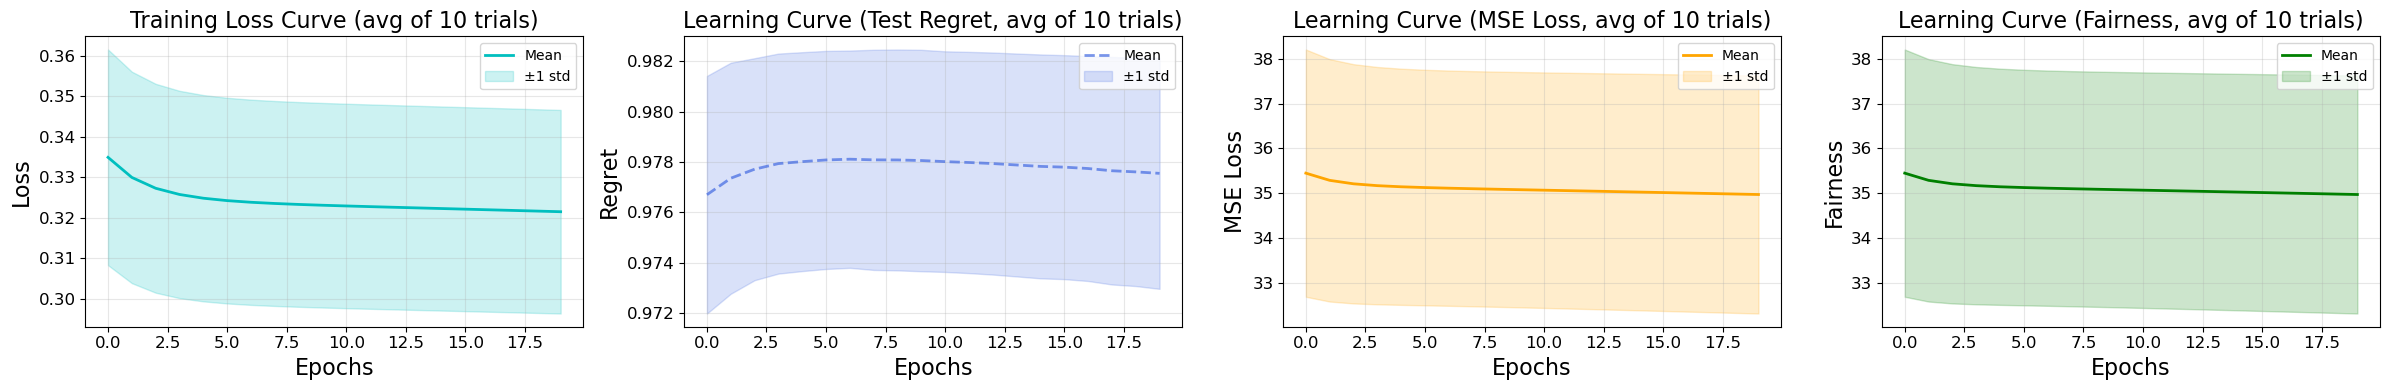

\begin{table}
\caption{ model Results $\alpha= $}
\label{tab:results}
\begin{tabular}{lcccccc}
\toprule
MSE (Mean ± Std) & Regret (Mean ± Std) & Fairness (Mean ± Std) & Time/Epoch \\
\midrule
34.97 ± 2.66 & 0.98 ± 0.00 & 34.969 ± 2.661 & 11.30 ± 0.14 \\
\bottomrule
\end{tabular}
\end{table}



In [92]:
alpha = 'inf'
# Run the multiple trials function
results = run_multiple_trials_lancer(feats, gainF, risk, cost, race, n_trials=10, test_size=0.5, lancer_params=lancer_params)

# Combine all results into a summary
data = {
    'MSE (Mean ± Std)': [
        f"{results['mean_test_mse'][-1]:.2f} ± {results['std_test_mse'][-1]:.2f}"
    ],
    'Regret (Mean ± Std)': [
        f"{results['mean_test_regret'][-1]:.2f} ± {results['std_test_regret'][-1]:.2f}"
    ],
    'Fairness (Mean ± Std)': [
        f"{results['mean_test_fair'][-1]:.3f} ± {results['std_test_fair'][-1]:.3f}"],
    'Time/Epoch': [
        f"{results['mean_time']:.2f} ± {results['std_time']:.2f}"
    ]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Export the DataFrame to LaTeX
latex_table = df.to_latex(index=False, column_format='lcccccc', 
                         caption=' model Results $\\alpha= $', 
                         label='tab:results')

print(latex_table)


Running trial 1/10
Warm-starting predictor...
Initial fit epoch 1, Predictor MSE Loss: 56.7303
initial regret 1.2059367647097186
Initial fit epoch 2, Predictor MSE Loss: 55.3966
initial regret 0.9485712914916621
Initial fit epoch 3, Predictor MSE Loss: 54.1373
initial regret 0.5705328883254918
Initial fit epoch 4, Predictor MSE Loss: 52.9525
initial regret 0.5469018789166081
Initial fit epoch 5, Predictor MSE Loss: 51.8401
initial regret 0.538092425671127
Initial fit epoch 6, Predictor MSE Loss: 50.7960
initial regret 0.5454908421461708
Initial fit epoch 7, Predictor MSE Loss: 49.8165
initial regret 0.5485682289319477
Initial fit epoch 8, Predictor MSE Loss: 48.8979
initial regret 0.5539004676221506
Initial fit epoch 9, Predictor MSE Loss: 48.0368
initial regret 0.561984848653149
Initial fit epoch 10, Predictor MSE Loss: 47.2303
initial regret 0.5685805269438429
Initial fit epoch 11, Predictor MSE Loss: 46.4758
initial regret 0.5773970329144436
Initial fit epoch 12, Predictor MSE Loss

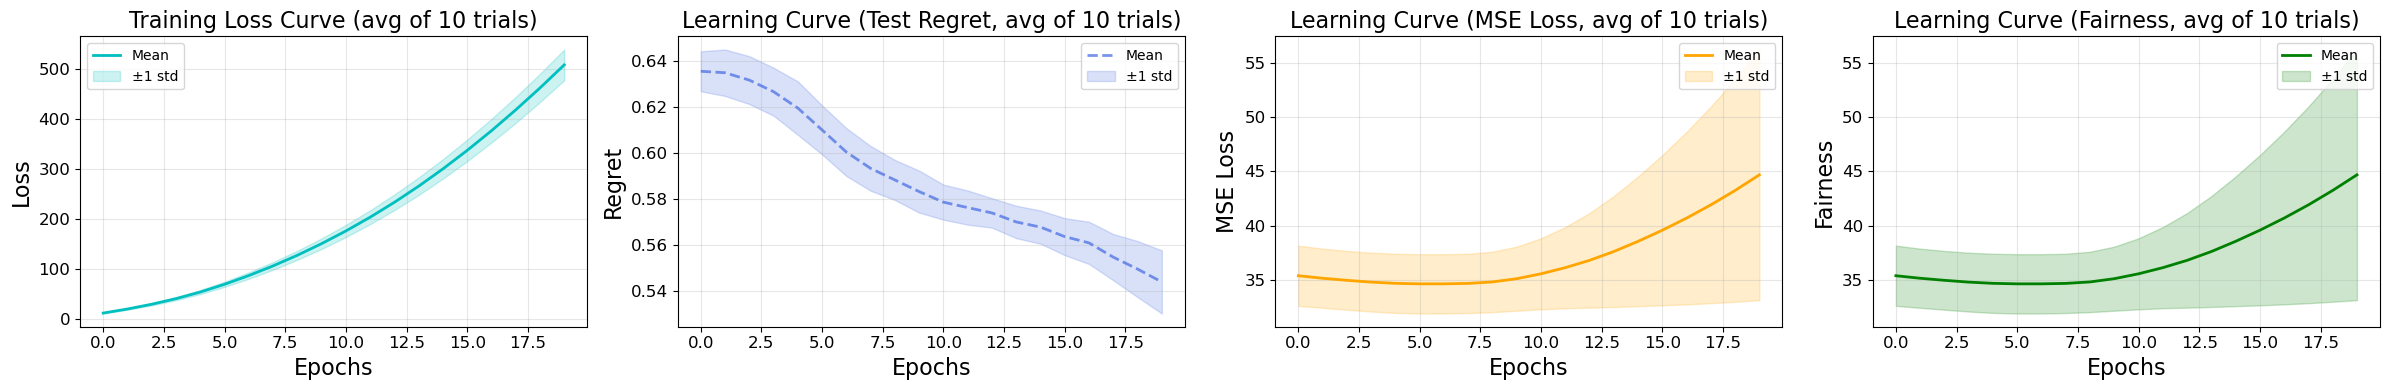

\begin{table}
\caption{ model Results $\alpha= $}
\label{tab:results}
\begin{tabular}{lcccccc}
\toprule
MSE (Mean ± Std) & Regret (Mean ± Std) & Fairness (Mean ± Std) & Time/Epoch \\
\midrule
44.69 ± 11.51 & 0.54 ± 0.01 & 44.686 ± 11.508 & 94.53 ± 11.23 \\
\bottomrule
\end{tabular}
\end{table}



In [93]:
alpha = 1.5
# Run the multiple trials function
results = run_multiple_trials_lancer(feats, gainF, risk, cost, race, n_trials=10, test_size=0.5, lancer_params=lancer_params)

# Combine all results into a summary
data = {
    'MSE (Mean ± Std)': [
        f"{results['mean_test_mse'][-1]:.2f} ± {results['std_test_mse'][-1]:.2f}"
    ],
    'Regret (Mean ± Std)': [
        f"{results['mean_test_regret'][-1]:.2f} ± {results['std_test_regret'][-1]:.2f}"
    ],
    'Fairness (Mean ± Std)': [
        f"{results['mean_test_fair'][-1]:.3f} ± {results['std_test_fair'][-1]:.3f}"],
    'Time/Epoch': [
        f"{results['mean_time']:.2f} ± {results['std_time']:.2f}"
    ]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Export the DataFrame to LaTeX
latex_table = df.to_latex(index=False, column_format='lcccccc', 
                         caption=' model Results $\\alpha= $', 
                         label='tab:results')

print(latex_table)


Running trial 1/10
Warm-starting predictor...
Initial fit epoch 1, Predictor MSE Loss: 56.7303
initial regret 0.35277796847958653
Initial fit epoch 2, Predictor MSE Loss: 55.3966
initial regret 0.38671289722203916
Initial fit epoch 3, Predictor MSE Loss: 54.1373
initial regret 0.5578415072007673
Initial fit epoch 4, Predictor MSE Loss: 52.9525
initial regret 0.5641751849658617
Initial fit epoch 5, Predictor MSE Loss: 51.8401
initial regret 0.5647107124290818
Initial fit epoch 6, Predictor MSE Loss: 50.7960
initial regret 0.5640233431714926
Initial fit epoch 7, Predictor MSE Loss: 49.8165
initial regret 0.5652924508124031
Initial fit epoch 8, Predictor MSE Loss: 48.8979
initial regret 0.5660539767865768
Initial fit epoch 9, Predictor MSE Loss: 48.0368
initial regret 0.5675058488719953
Initial fit epoch 10, Predictor MSE Loss: 47.2303
initial regret 0.5689417854931558
Initial fit epoch 11, Predictor MSE Loss: 46.4758
initial regret 0.5708811283313434
Initial fit epoch 12, Predictor MSE 

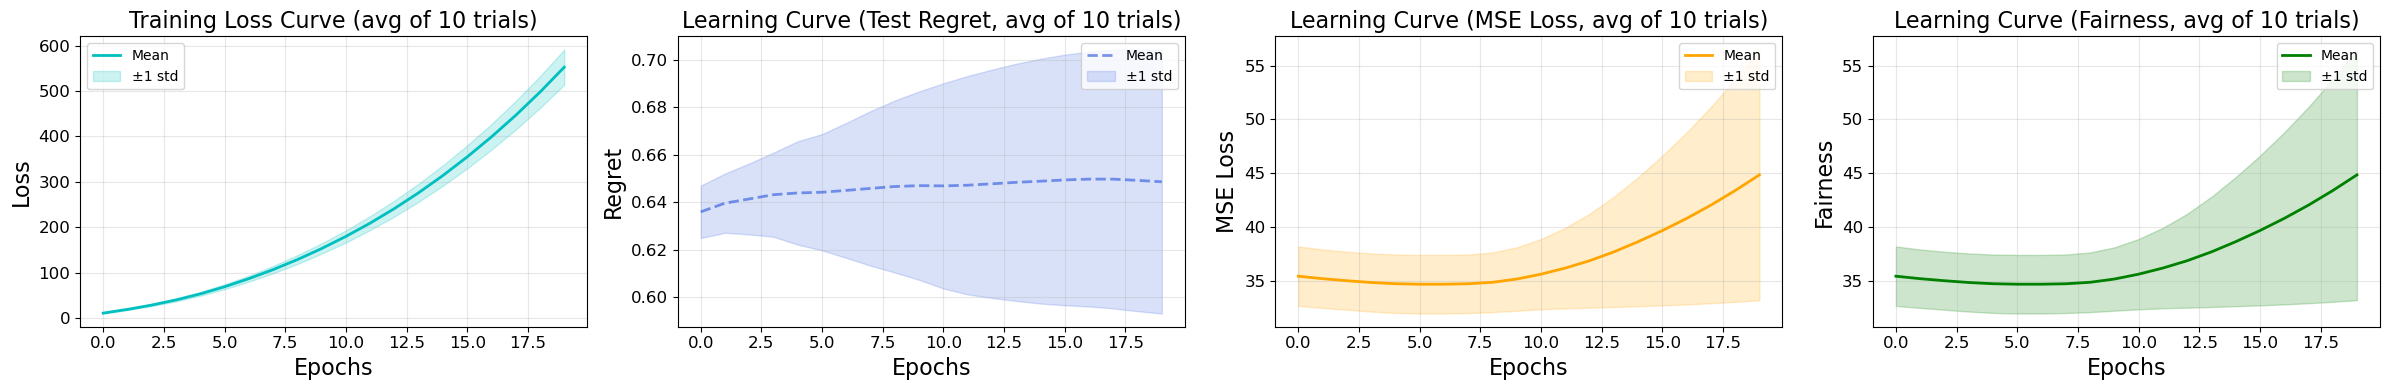

\begin{table}
\caption{ model Results $\alpha= $}
\label{tab:results}
\begin{tabular}{lcccccc}
\toprule
MSE (Mean ± Std) & Regret (Mean ± Std) & Fairness (Mean ± Std) & Time/Epoch \\
\midrule
44.84 ± 11.66 & 0.65 ± 0.06 & 44.843 ± 11.655 & 44.70 ± 4.96 \\
\bottomrule
\end{tabular}
\end{table}



In [94]:
alpha = 0.5
# Run the multiple trials function
results = run_multiple_trials_lancer(feats, gainF, risk, cost, race, n_trials=10, test_size=0.5, lancer_params=lancer_params)

# Combine all results into a summary
data = {
    'MSE (Mean ± Std)': [
        f"{results['mean_test_mse'][-1]:.2f} ± {results['std_test_mse'][-1]:.2f}"
    ],
    'Regret (Mean ± Std)': [
        f"{results['mean_test_regret'][-1]:.2f} ± {results['std_test_regret'][-1]:.2f}"
    ],
    'Fairness (Mean ± Std)': [
        f"{results['mean_test_fair'][-1]:.3f} ± {results['std_test_fair'][-1]:.3f}"],
    'Time/Epoch': [
        f"{results['mean_time']:.2f} ± {results['std_time']:.2f}"
    ]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Export the DataFrame to LaTeX
latex_table = df.to_latex(index=False, column_format='lcccccc', 
                         caption=' model Results $\\alpha= $', 
                         label='tab:results')

print(latex_table)